# Linear feedback: discrete-time full state feedback

Homogeneous platoon, using methods from chapter 4 of Cooperative Control of Multi-Agent Systems by Lewis et. al.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from utils.graphs import kpf_graph
from utils.step_reference import gen_step_ref
from utils.plotting import plot_traj, plot_errors

In [2]:
N = 10
M, D, L, P = kpf_graph(N)
Gamma = np.linalg.inv(np.eye(N) + D + P) @ (L + P)

In [3]:
tau = 0.1
dt = 0.1
A = np.array([[1, dt, 0],
              [0, 1, dt],
              [0, 0, 1-dt/tau]])
B = np.array([[0], [0], [dt/tau]])
n = A.shape[0]
m = B.shape[1]

## Leader trajectory

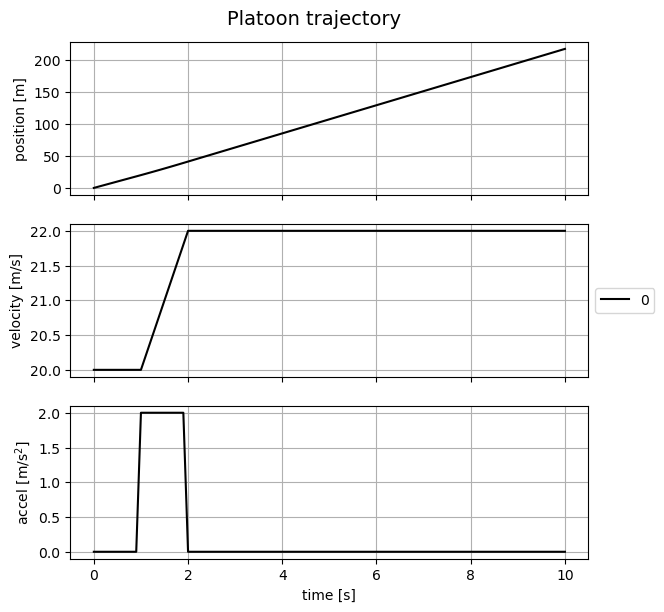

In [4]:
dist_start = 1.0 - dt
dist_end = 2.0 - dt
v_start = 20.
v_end = 22.
t_total = 10.0

x_ref, t_range = gen_step_ref(t_total, dt, dist_start, dist_end, v_start, v_end)
plot_traj(t_range, [x_ref], labels=[0])

## Platooning using DT-ARE to select gains

In [6]:
# controller parameters
Q = np.diag([20., 20., 1.])
R = 0.1*np.eye(m)
F = sp.linalg.solve_discrete_are(A, B, Q, R)
K = np.linalg.inv(B.T @ F @ B) @ B.T @ F @ A

# center and radius of circle containing eigenvalues of Gamma
# will be 0.5 and 0.0 for PF case
c0 = np.linalg.eigvals(Gamma)[0]
r0 = 0.  # Gamma lower triangular, all eigenvalues are 0.5
Q_neg_half = sp.linalg.sqrtm(sp.linalg.inv(Q))
r = np.linalg.svd(
    Q_neg_half.T @ K.T @ B.T @ F @ B @ K @ Q_neg_half
)[1][0]
assert r0 / c0 < r
c = 1 / c0

In [ ]:
# platoon/error trajectories and initial conditions
x_platoon = [np.zeros((n, len(t_range))) for _ in range(N+1)]
u_platoon = [np.zeros((m, len(t_range))) for _ in range(N+1)]
x_platoon[0][:, :] = x_ref
u_platoon[0][:, :] = x_ref[2, :]
e_platoon = [np.zeros((n, len(t_range))) for _ in range(N+1)]
d_des = 5.
for i in range(1, N+1):
    x_platoon[i][:, 0] = x_platoon[0][:, 0] - np.array([(i-1)*d_des, 0., 0.])

In [7]:
# simulate platoon
for k in range(len(t_range)-1):
    for i in range(1, N+1):
        d_tilde = np.array([d_des, 0., 0.]) if i != 1 else np.zeros(n)
        e = x_platoon[i-1][:, k] - x_platoon[i][:, k] - d_tilde
        u = c / (1 + D[i-1, i-1] + P[i-1, i-1]) * K @ e
        x_platoon[i][:, k+1] = A @ x_platoon[i][:, k] + B @ u
        e_platoon[i][:, k] = e
        u_platoon[i][:, k] = u
for i in range(1, N+1):
    d_tilde = np.array([d_des, 0., 0.]) if i != 1 else np.zeros(n)
    e_platoon[i][:, -1] = x_platoon[i-1][:, -1] - x_platoon[i][:, -1] - d_tilde

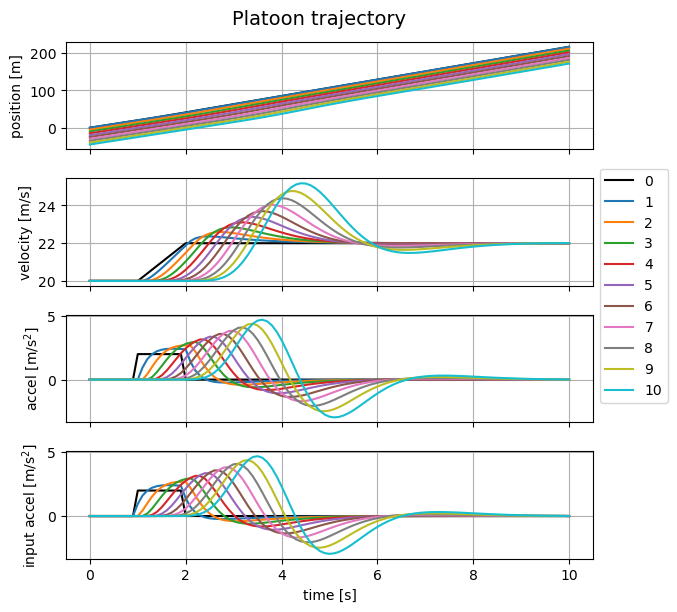

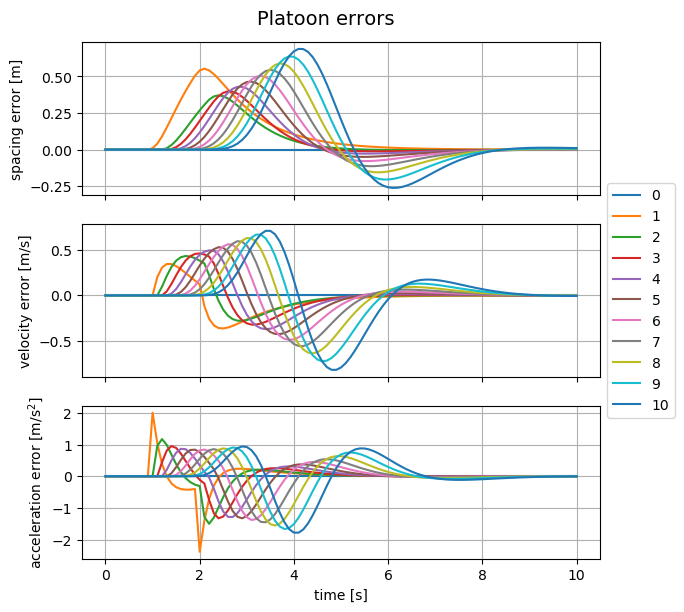

In [8]:
plot_inds = range(N+1)  #[1, 3, 5, 7, 10]
x_plot = [x_platoon[ind] for ind in plot_inds]
e_plot = [e_platoon[ind] for ind in plot_inds]
x_u_plot = [np.concatenate((x_platoon[ind], u_platoon[ind]), axis=0) for ind in plot_inds]
plot_traj(t_range, x_u_plot, labels=plot_inds)
plot_errors(t_range, e_plot, "Platoon errors", plot_inds)